In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from unet_model import UNet
from torchvision.transforms.functional import gaussian_blur
from torchsummary import summary
from tqdm import tqdm
import imageio
import cv2

torch.manual_seed(0);

In [4]:
Frames = 512
dt = 0.1
n = 128     # Resolution (== width == height == no. particles)

# Load different timelines
n_timelines = 10

inputs = []
outputs = []

for i in range(n_timelines):
    timeline = torch.load(f"../data-gen/data/n_{n}_dt_{dt}_F_{Frames}/voxel/{i:06}.pt", weights_only=True)
    G = timeline["G"]
    frames = timeline["frames"]
    inputs.append(frames[:-1])
    outputs.append(frames[1:])

_, N_CHANNELS, WIDTH, HEIGHT = frames.shape

inputs = torch.concatenate(inputs, dim=0).cuda()
outputs = torch.concatenate(outputs, dim=0).cuda()
assert inputs.shape == outputs.shape, "Inputs and outputs do not have the same shape"

N_SAMPLES = len(inputs)

permutation = torch.randperm(n=N_SAMPLES)
inputs = inputs[permutation]
outputs = outputs[permutation]

N_TRAIN_SAMPLES = round(N_SAMPLES * 0.9)
train_inputs = inputs[:N_TRAIN_SAMPLES]
train_outputs = outputs[:N_TRAIN_SAMPLES]
val_inputs = inputs[N_TRAIN_SAMPLES:]
val_outputs = inputs[N_TRAIN_SAMPLES]

print(f"N_CHANNELS={N_CHANNELS}, WIDTH={WIDTH}, HEIGHT={HEIGHT}")
print(f"inputs.shape: {inputs.shape}")

N_CHANNELS=4, WIDTH=128, HEIGHT=128
inputs.shape: torch.Size([5110, 4, 128, 128])


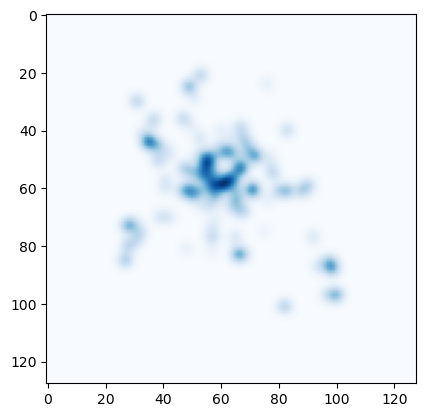

In [5]:
plt.imshow(gaussian_blur(train_inputs[0:1,2,:,:] * 10, kernel_size=11)[0].cpu().detach().numpy(), cmap="Blues")

In [39]:
unet = UNet(n_channels=4, n_classes=4).cuda()
summary(unet, input_size=(4, HEIGHT, WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           2,304
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
        DoubleConv-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,728
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,456
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14          [-1, 128,

## Training loop

In [40]:
print(f"Inputs size: {train_inputs.nbytes / (1024**3):.3f} GB")

Inputs size: 1.123 GB


In [41]:
channel_loss_weights = torch.tensor([1, 1, 1, 1], dtype=torch.float32).cuda()

def loss_fun(output, truth):
    assert len(output.shape) == 4, "Expect output to be of shape (batch_size, n_channels, height, width)"
    assert len(truth.shape) == 4, "Expect truth to be of shape (batch_size, n_channels, height, width)"

    diff = ((output - truth)**2)
    return torch.flatten(diff).mean()

    weighted_diff = (diff.mean(2).mean(2) * channel_loss_weights[None,:])  # (batch_size, 4)
    return weighted_diff.mean(0).sum()

loss: 9.133739471435547


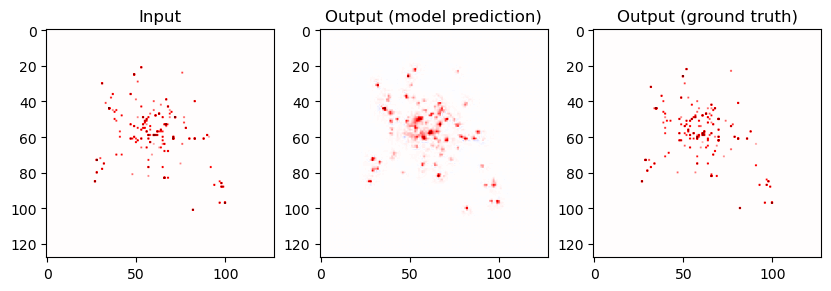

In [48]:
idx = 0

x = train_inputs[idx:idx+1]
out = unet(x)
loss = loss_fun(out, x)

v_mag = 4

fig, axs = plt.subplots(1, 3, figsize=(10, 20))
axs[0].imshow(train_inputs[idx][2].cpu(), cmap="seismic", vmin=-v_mag, vmax=v_mag)
axs[0].set_title("Input")
axs[1].imshow(out[0][2].cpu().detach().numpy(), cmap="seismic", vmin=-v_mag, vmax=v_mag)
axs[1].set_title("Output (model prediction)")
axs[2].imshow(train_outputs[idx][2].cpu(), cmap="seismic", vmin=-v_mag, vmax=v_mag)
axs[2].set_title("Output (ground truth)")

print(f"loss: {loss}")

In [43]:
loss_history = []

In [44]:
lr = 0.001
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

In [45]:
batch_size = 16

for _ in range(1):
    pbar = tqdm(range(0, len(train_inputs), batch_size))
    for i in pbar:
        # Every data instance is an input + label pair

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        end_index = min(i + batch_size, len(train_inputs))
        inputs = train_inputs[i:end_index]
        truth = train_outputs[i:end_index]
        outputs = unet(inputs)

        # Compute the loss and its gradients
        loss = loss_fun(outputs, truth)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        loss_history.append(loss.item())
        pbar.set_description(f"training loss: {np.mean(loss_history[-batch_size:]):.5f}")

    permutation = torch.randperm(n=len(train_inputs)).cuda()
    inputs = train_inputs[permutation]
    outputs = train_outputs[permutation]

training loss: 3.37039: 100%|██████████| 288/288 [00:29<00:00,  9.93it/s]


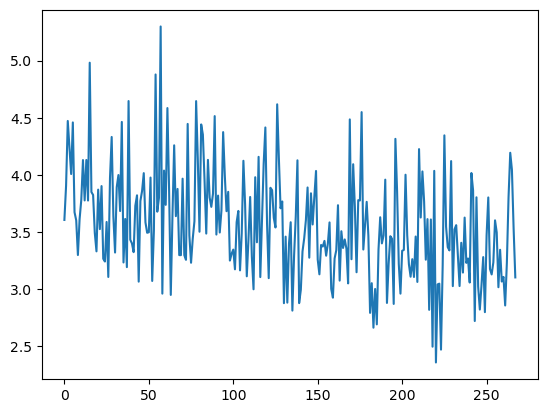

In [47]:
plt.plot([loss for loss in loss_history][20::])
# plt.ylim(0, 2)

## View distribution of input

train_inputs.shape: torch.Size([4599, 4, 128, 128])
torch.Size([4, 16384])


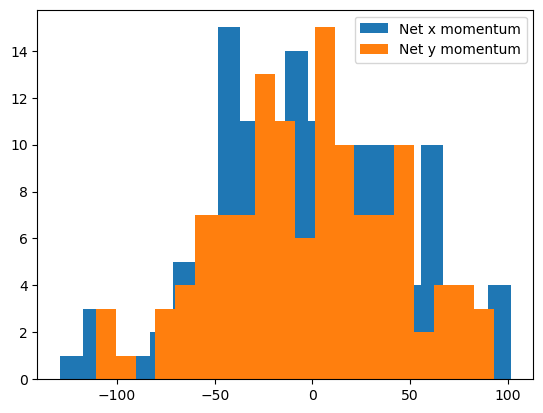

In [30]:
print(f"train_inputs.shape:", train_inputs.shape)
x = train_inputs[0].cpu().flatten(start_dim=1, end_dim=2)
print(x.shape)

plt.hist(x[0][x[0] != 0], bins=20, label="Net x momentum");
plt.hist(x[1][x[1] != 0], bins=20, label="Net y momentum");
plt.legend();

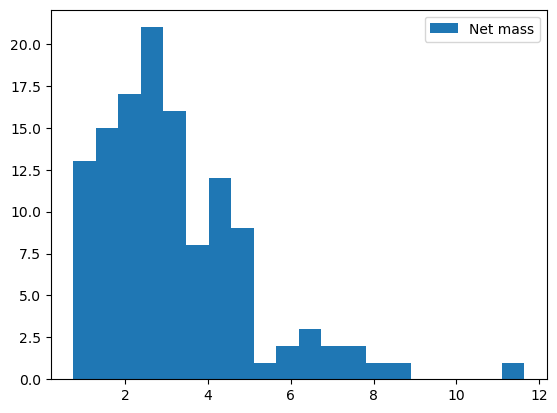

In [31]:
plt.hist(x[2][x[2] != 0], bins=20, label="Net mass");
plt.legend();

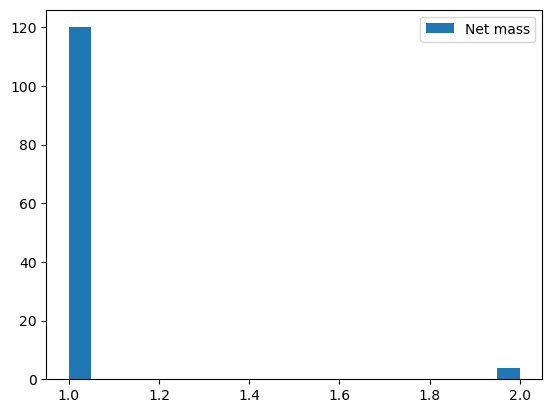

In [32]:
plt.hist(x[3][x[3] != 0], bins=20, label="Net mass");
plt.legend();

## Generate animation

In [50]:
x = frames[0:1].cuda()

rendered_frames = []
fig, ax = plt.subplots(figsize=(5.12, 5.12), dpi=100)
fig.patch.set_facecolor('black')

with torch.no_grad():
    for i in tqdm(range(90), ncols=80):
        ax.clear()
        ax.set_xlim(0, WIDTH)
        ax.set_ylim(0, HEIGHT)
        ax.imshow(unet(x)[0][2].cpu().detach().numpy(), cmap="Blues", vmin=0, vmax=1)
        plt.axis("off")
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype="uint8")
        image = image.reshape(fig.canvas.get_width_height() + (4,))
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        # Make the image writable by creating a copy
        image = image.copy()
        rendered_frames.append(image)

        x = unet(x) #frames[i:i+1].cuda()

plt.close()

print(f"Finished rendering, saving to MP4...")
imageio.mimsave(f"./unet_render.mp4", rendered_frames, fps=30)  

100%|███████████████████████████████████████████| 90/90 [00:04<00:00, 20.42it/s]


Finished rendering, saving to MP4...
